In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

In [320]:
df = pd.read_csv('patient_dataset.csv')

In [321]:
print("Shape of dataset:", df.shape)
display(df.head())

print("\nDataset Info:")
print(df.info())
print("\nMissing values:\n", df.isna().sum())

Shape of dataset: (6000, 16)


,age,gender,chest_pain_type,blood_pressure,cholesterol,max_heart_rate,exercise_angina,plasma_glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,residence_type,smoking_status
0,24,1.0,4,250,139,212,0,108.0,33.0,109.0,37.999303,0.480277,1,1,Urban,Smoker
1,29,0.0,4,132,187,147,0,202.0,42.0,NaN,25.588346,0.283986,1,1,Urban,Unknown
2,46,0.0,3,271,185,193,0,149.0,43.0,102.0,37.892029,2.472309,1,0,Rural,Non-Smoker
3,73,NaN,2,102,200,125,0,105.0,77.0,165.0,18.660241,1.472052,0,1,Rural,Smoker
4,49,1.0,3,91,163,192,0,162.0,31.0,170.0,12.767980,0.537627,1,1,Rural,Smoker



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6000 non-null   int64  
 1   gender             5528 non-null   float64
 2   chest_pain_type    6000 non-null   int64  
 3   blood_pressure     6000 non-null   int64  
 4   cholesterol        6000 non-null   int64  
 5   max_heart_rate     6000 non-null   int64  
 6   exercise_angina    6000 non-null   int64  
 7   plasma_glucose     5391 non-null   float64
 8   skin_thickness     5386 non-null   float64
 9   insulin            5432 non-null   float64
 10  bmi                6000 non-null   float64
 11  diabetes_pedigree  6000 non-null   float64
 12  hypertension       6000 non-null   int64  
 13  heart_disease      6000 non-null   int64  
 14  residence_type     5545 non-null   object 
 15  smoking_status     6000 non-null   object 
dtypes: float6

In [322]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns


df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print(df.isna().sum())

age                  0
gender               0
chest_pain_type      0
blood_pressure       0
cholesterol          0
max_heart_rate       0
exercise_angina      0
plasma_glucose       0
skin_thickness       0
insulin              0
bmi                  0
diabetes_pedigree    0
hypertension         0
heart_disease        0
residence_type       0
smoking_status       0
dtype: int64


In [323]:
df.duplicated().sum()

np.int64(0)

In [324]:
numeric_cols = ['age', 'blood_pressure', 'cholesterol', 'max_heart_rate',
                'plasma_glucose', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree']
categorical_cols = ['gender', 'chest_pain_type', 'exercise_angina',
                    'hypertension', 'heart_disease', 'residence_type', 'smoking_status']

In [325]:

skew_values = df[numeric_cols].skew()
print("Skewness of numeric columns:\n", skew_values)


Skewness of numeric columns:
 age                  0.030718
blood_pressure       0.089403
cholesterol          0.005312
max_heart_rate       0.007490
plasma_glucose      -0.042959
skin_thickness      -0.010537
insulin              0.025759
bmi                  0.003675
diabetes_pedigree   -0.001205
dtype: float64


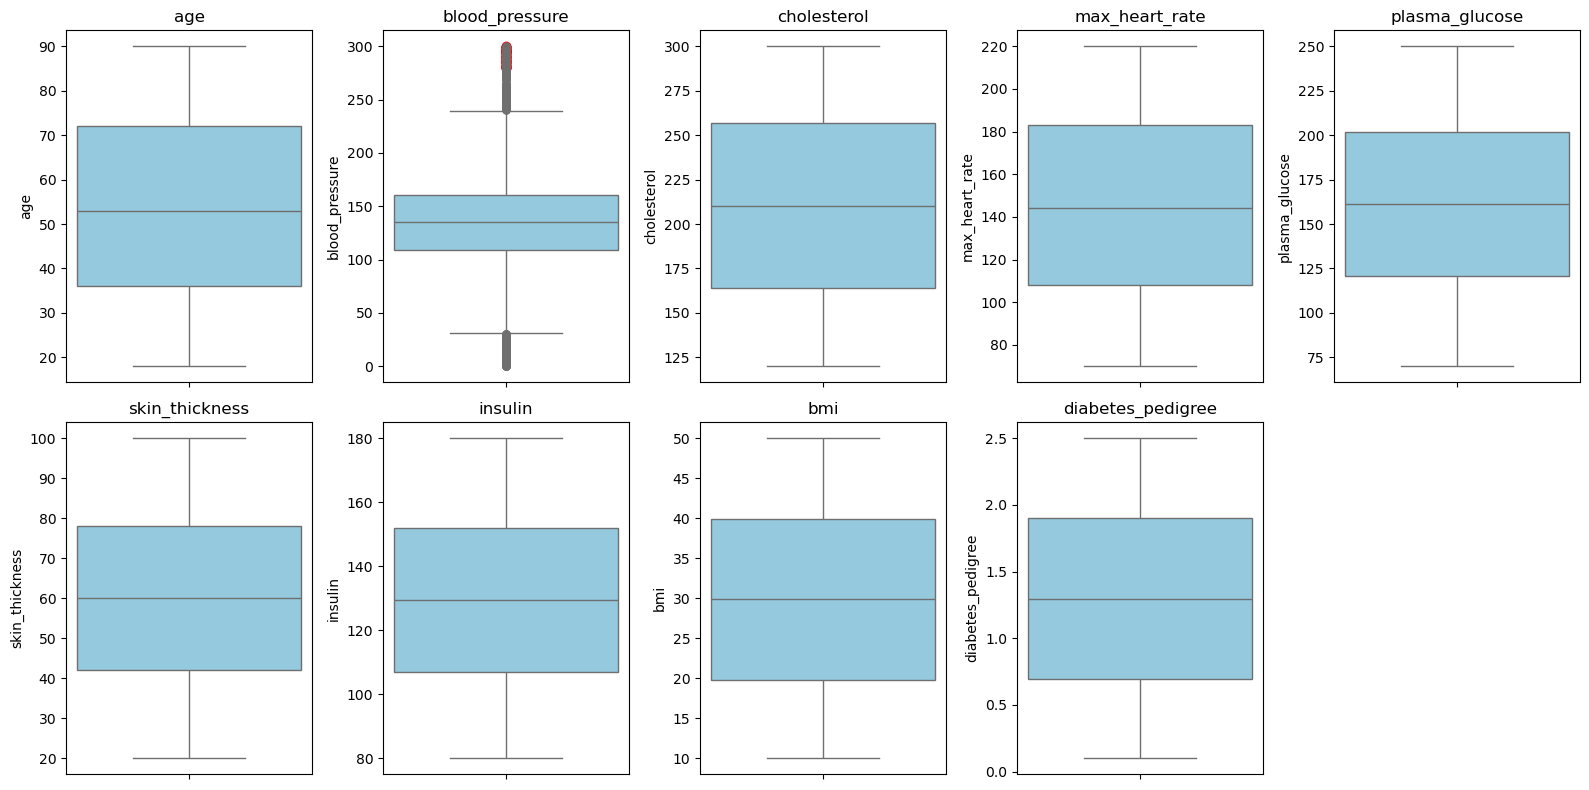

In [326]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore


z_scores = np.abs(zscore(df[numeric_cols]))
outliers_mask = (z_scores > 3)  


plt.figure(figsize=(16, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 5, i + 1) 
    
    outlier_points = df[col][outliers_mask[:, i]]
    
    sns.boxplot(y=df[col], color='skyblue', fliersize=5,
                flierprops=dict(marker='o', color='red', alpha=0.7))
    plt.scatter(np.full(outlier_points.shape, 0), outlier_points, color='red', alpha=0.7, label='Outliers')
    plt.title(col)
    plt.tight_layout()

plt.show()


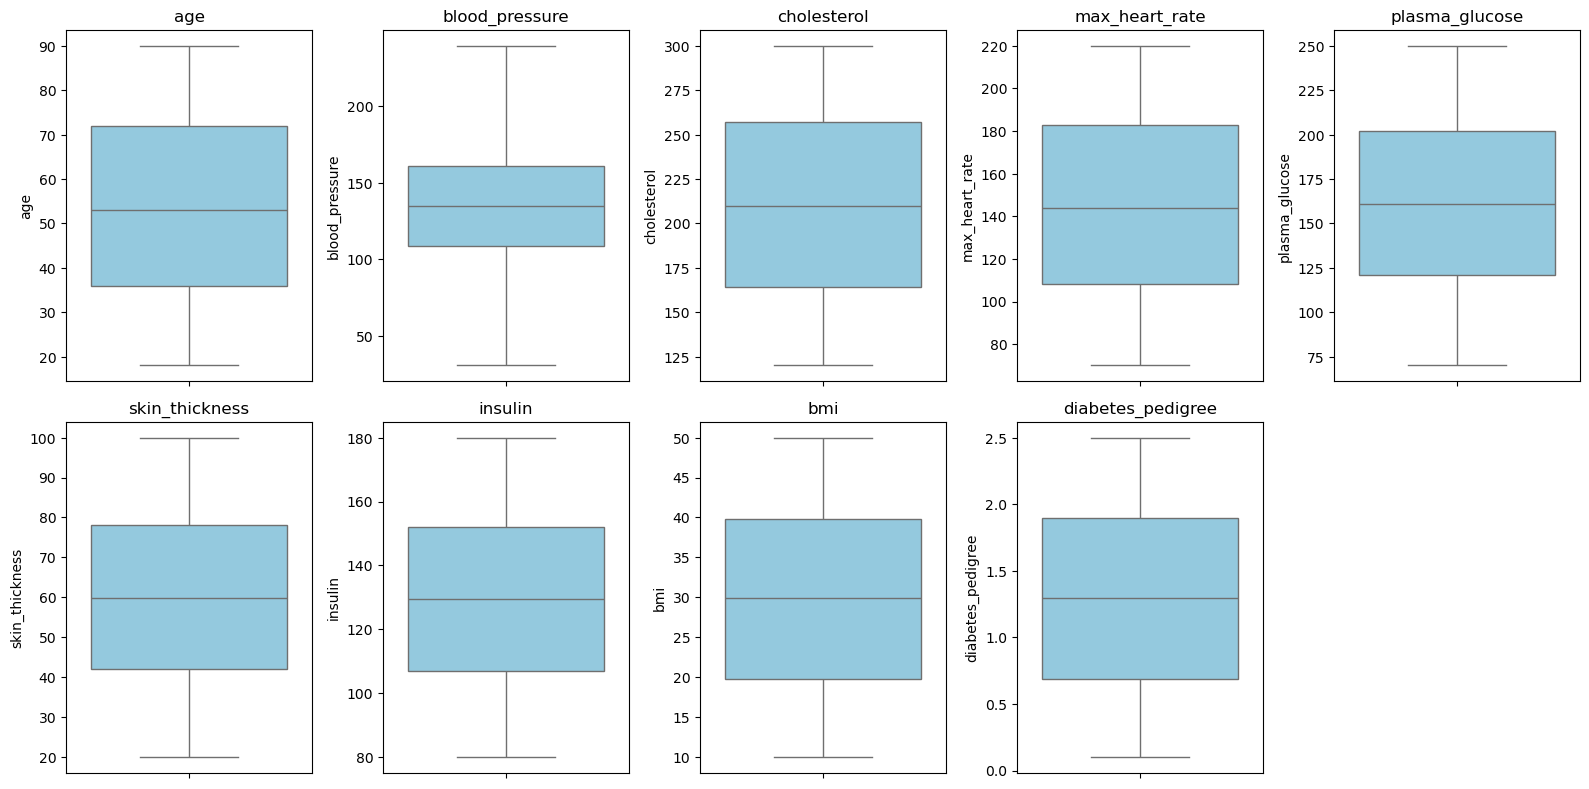

In [327]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Winsorize using IQR (replace outliers with bounds) ---
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound,
                       np.where(df[col] > upper_bound, upper_bound, df[col]))

# --- Plot boxplots with sky blue color ---
plt.figure(figsize=(16, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 5, i+1)
    sns.boxplot(y=df[col], color='skyblue')  # set color here
    plt.title(col)
plt.tight_layout()
plt.show()


In [328]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=['object', 'category']).columns

le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  


display(df.head())

,age,gender,chest_pain_type,blood_pressure,cholesterol,max_heart_rate,exercise_angina,plasma_glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,residence_type,smoking_status
0,24.0,1.000000,4,239.0,139.0,212.0,0,108.0,33.0,109.000000,37.999303,0.480277,1,1,1,1
1,29.0,0.000000,4,132.0,187.0,147.0,0,202.0,42.0,129.601252,25.588346,0.283986,1,1,1,2
2,46.0,0.000000,3,239.0,185.0,193.0,0,149.0,43.0,102.000000,37.892029,2.472309,1,0,0,0
3,73.0,0.497648,2,102.0,200.0,125.0,0,105.0,77.0,165.000000,18.660241,1.472052,0,1,0,1
4,49.0,1.000000,3,91.0,163.0,192.0,0,162.0,31.0,170.000000,12.767980,0.537627,1,1,0,1


In [329]:

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
X = df.drop(columns=['heart_disease'])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(" X_scaled created successfully with shape:", X_scaled.shape)


 X_scaled created successfully with shape: (6000, 15)


In [330]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[ 1.83358169, -2.1625942 ],
       [-0.08430653, -1.31776049],
       [ 1.35761467, -0.75804612],
       ...,
       [-1.18722079,  1.22339266],
       [-0.19083563,  0.25388978],
       [ 0.39131918,  0.7568467 ]])

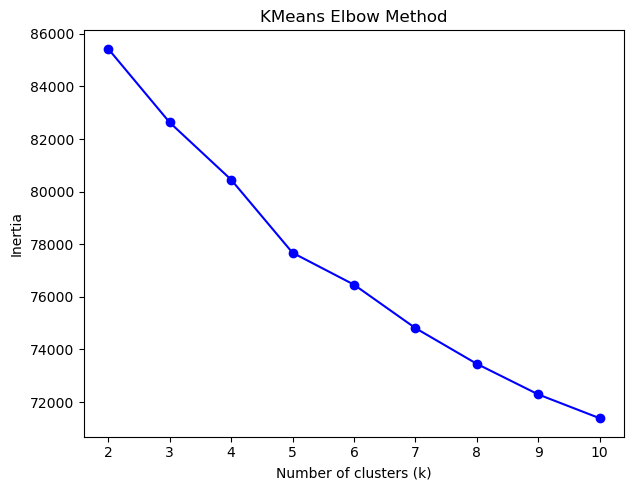

In [331]:
K = range(2, 11)

inertias = []
sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels = km.fit_predict(X_scaled)  
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, km_labels)
    sil_scores.append(sil)

#  Elbow Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o', color='blue')
plt.title("KMeans Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")


plt.tight_layout()
plt.show()

In [332]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_pca)
print(df['kmeans_cluster'].value_counts())

kmeans_cluster
1    3053
0    2947
Name: count, dtype: int64


In [333]:
from sklearn.metrics import silhouette_score
sil_score_km = silhouette_score(X_pca, df['kmeans_cluster'])
print(f"Silhouette Score: {sil_score_km:.3f}")

Silhouette Score: 0.306


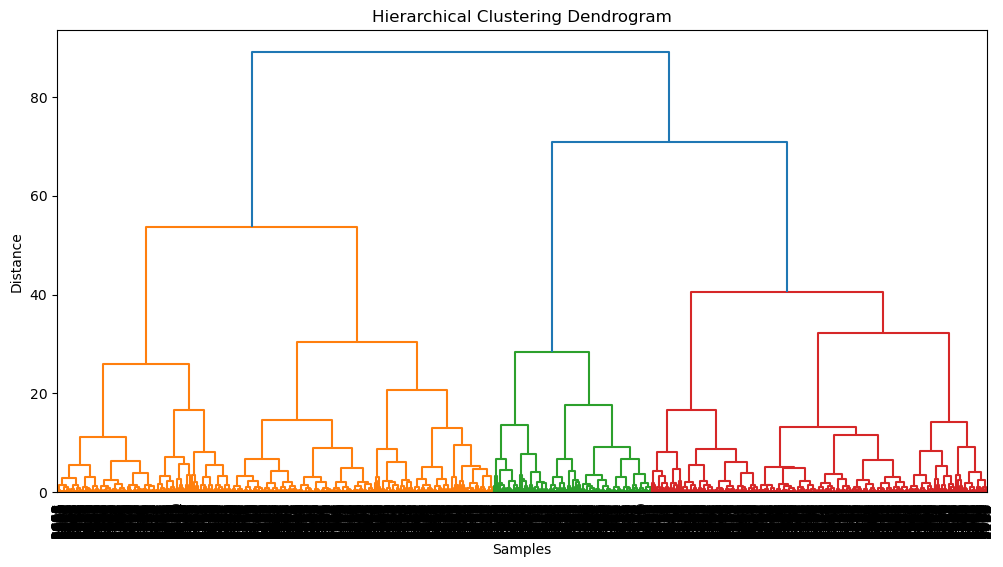

Hierarchical Silhouette Score: 0.2966


In [334]:
# ----- Hierarchical Clustering -----
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

Z = linkage(X_pca, method='ward') 

plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    leaf_rotation=90.,       
    leaf_font_size=10.,    
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


n_clusters = 2
hier_labels = fcluster(Z, t=n_clusters, criterion='maxclust')

df['hierarchical_cluster'] = hier_labels
sil_score_hi = silhouette_score(X_pca, hier_labels)
print(f"Hierarchical Silhouette Score: {sil_score_hi:.4f}")



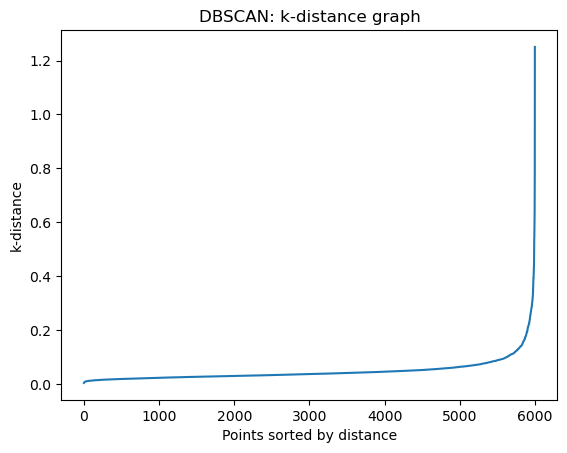

In [335]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)
distances = np.sort(distances[:,-1])
plt.plot(distances)
plt.ylabel("k-distance")
plt.xlabel("Points sorted by distance")
plt.title("DBSCAN: k-distance graph")
plt.show()

In [336]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.3, min_samples=3)  
df['dbscan_cluster'] = dbscan.fit_predict(X_pca)
print(df['dbscan_cluster'].value_counts())

dbscan_cluster
 0    5971
-1      25
 1       4
Name: count, dtype: int64


In [337]:
mask = df['dbscan_cluster'] != -1
sil_score_db = silhouette_score(X_pca[mask], df['dbscan_cluster'][mask])
print(f"Silhouette Score: {sil_score_db:.3f}")

Silhouette Score: 0.392


In [338]:
print(f"{'Algorithm':<15} | {'Silhouette':<10}")
print(f"{'K-Means':<15} | {sil_score_km:<10.3f}")
print(f"{'Hierarchical':<15} | {sil_score_hi:<10.3f}")
print(f"{'DBSCAN':<15} | {sil_score_db:<10.3f}")

Algorithm       | Silhouette
K-Means         | 0.306     
Hierarchical    | 0.297     
DBSCAN          | 0.392     
